In [1]:
import autoreload
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_KERAS"] = "1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

In [4]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input , Dense, Lambda, Normalization, Concatenate
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, schedules
from tensorflow_addons.optimizers import AdamW, extend_with_decoupled_weight_decay

from tensorflow.keras.callbacks import ModelCheckpoint, TerminateOnNaN, TensorBoard, \
                                        EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

import numpy as np
import random
import os

import gc

from tqdm import tqdm 

In [5]:
import import_ipynb

from modules import convkxf, GroupFC#, GroupGRULayer

from loss import MaskLoss, LocalSnrTarget, DfAlphaLoss, SpectralLoss
from utils import mask_operations, df_operations, synthesis_frame, df_operations_fast
from params import model_params
from dataloader import read_tfrecod_data
from bandERB import ERBBand, ERB_pro_matrix

importing Jupyter notebook from modules.ipynb
importing Jupyter notebook from loss.ipynb
importing Jupyter notebook from bandERB.ipynb
importing Jupyter notebook from params.ipynb
importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from dataloader.ipynb


In [6]:
stateful = False
gru_norm, fc_norm = False, False
if stateful: from modules import GroupGRULayer_stateful as GroupGRULayer
else: from modules import GroupGRULayer_lite as GroupGRULayer

In [7]:
# from tensorflow.compat.v1 import ConfigProto, InteractiveSession, enable_eager_execution

# config = ConfigProto(allow_soft_placement=True)
# config.gpu_options.per_process_gpu_memory_fraction = 0.6
# config.gpu_options.allow_growth = True
# InteractiveSession(config=config)
# enable_eager_execution(config=config)

# # tf.compat.v1.disable_eager_execution()

# Read config

In [8]:
p = model_params('config.ini')

In [9]:
def as_complex(x):
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        return x
    else:
        return np.complex(x[...,-2], x[..., -1])

def as_real(x):
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        return np.concatenate([np.expand_dims(np.real(x),axis=-1), 
                               np.expand_dims(np.imag(x),axis=-1)],axis=-1)
    else: return x

In [10]:
gru_layer = 2
p.fc_group = 8
p.gru_group = 1

# Model construction

In [11]:
if stateful: time = None
else: time = 3
    
erb_inputs = Input(shape=(time, p.nb_erb, 1), batch_size=1, name='ERB_input')
spec_inputs = Input(shape=(time, p.nb_df, 2), batch_size=1, name='spec_input') # complex

state = Input(shape=(256), batch_size=1, name='state0')

state10 = Input(shape=(256), batch_size=1, name='state10')
state11 = Input(shape=(256), batch_size=1, name='state11')
state1 = [state10, state11]

state20 = Input(shape=(256), batch_size=1, name='state20')
state21 = Input(shape=(256), batch_size=1, name='state21')

if gru_layer>1:
    state1 = [state10, state11]
    state2 = [state20, state21]
else:
    state1 = [state10]
    state2 = [state20]

In [12]:
erb_conv0 = convkxf(erb_inputs, p.conv_out_ch, k=3, f=3, fstride=1, bias=False, batch_norm=True, 
                    training=False, name='conv0_encoder')
erb_conv1 = convkxf(erb_conv0, p.conv_out_ch, k=1, f=3, fstride=2, bias=False, batch_norm=True, 
                     name='conv1_encoder')
erb_conv2 = convkxf(erb_conv1, p.conv_out_ch, k=1, f=3, fstride=2, bias=False, batch_norm=True, 
                     name='conv2_encoder')
erb_conv3 = convkxf(erb_conv2, p.conv_out_ch, k=1, f=3, fstride=1, bias=False, batch_norm=True, 
                     name='conv3_encoder')

df_conv0 = convkxf(spec_inputs, p.conv_out_ch, k=3, f=3, fstride=1, batch_norm=True, 
                   training=False,  name='df_conv0_encoder')
df_conv1 = convkxf(df_conv0, p.conv_out_ch, k=1, f=3, fstride=2, batch_norm=True, 
                    name='df_conv1_encoder')

shape = [tf.shape(df_conv1)[l] for l in range(4)]
df_conv1 = tf.transpose(df_conv1,(0,1,3,2))
df_conv1 = tf.reshape(df_conv1, [shape[0], shape[1], shape[2]*shape[3]])

cemb = GroupFC(df_conv1, p.fc_hidden, p.fc_group, name='GFC_encoder')
    
shape = [tf.shape(erb_conv3)[l] for l in range(4)]  
emb = Concatenate()([tf.reshape(tf.transpose(erb_conv3,(0,1,3,2)), [shape[0], shape[1], shape[2]*shape[3]]), cemb])

if p.model_ver == "3.0":
    emb = GroupFC(emb, p.gru_hidden, p.fc_group, name='GFC_emb')
    
if stateful:
    GRU_emb = GroupGRULayer(emb, p.gru_hidden, p.gru_group, num_layer=1, name='GGRU0', 
                               add_output=True, training=False, norm=gru_norm)
else:

    GRU_emb, lstate_o = GroupGRULayer(emb, p.gru_hidden, p.gru_group, num_layer=1, state=[state], name='GGRU0', 
                               add_output=True, training=False, norm=gru_norm)

{'filters': 64, 'groups': 1, 'kernel_size': (3, 3), 'strides': (1, 1), 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'conv0_encoder'}
{'filters': 64, 'groups': 64, 'kernel_size': (1, 3), 'strides': (1, 2), 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'conv1_encoder'}
{'filters': 64, 'groups': 64, 'kernel_size': (1, 3), 'strides': (1, 2), 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'conv2_encoder'}
{'filters': 64, 'groups': 64, 'kernel_size': (1, 3), 'strides': (1, 1), 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'conv3_encoder'}
{'filters': 64, 'groups': 2, 'kernel_size': (3, 3), 'strides': (1, 1), 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'df_conv0_encoder'}
{'filters': 64, 'groups': 64, 'kernel_size': (1, 3), 'strides': (1, 2), 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid'

In [13]:
if stateful:
    GRU_emb1 = GroupGRULayer(GRU_emb, p.gru_hidden, p.gru_group, num_layer=gru_layer, name='GGRU01', 
                               add_output=True, training=False, norm=gru_norm)
else:
    GRU_emb1, lstate1_o = GroupGRULayer(GRU_emb, p.gru_hidden, p.gru_group, num_layer=gru_layer, state=state1, name='GGRU01', 
                                 add_output=True, training=False, norm=gru_norm)
de_emb = GroupFC(GRU_emb1, p.fc_hidden, p.fc_group, activation='relu', 
                 name='GFC_decoder', norm=fc_norm)

shape = [tf.shape(erb_conv3)[l] for l in range(4)]
emb_decoder = tf.reshape(de_emb, shape = [shape[0], shape[1], shape[2], -1], name='decoder_reshape')

kwargs = {
    "k": 1,
    "batch_norm": True,
}
tkwargs = {
    "k": 1,
    "batch_norm": True,
    "mode": "transposed"
}
pkwargs = {
    "k": 1,
    "f": 1,
    "batch_norm": True
}

convp3 = convkxf(erb_conv3, out_ch=p.conv_out_ch, name='convp3', **pkwargs)  # Conv
vt3_in = convp3 + emb_decoder
convt3 = convkxf(vt3_in, out_ch=p.conv_out_ch, fstride=1, name='convt3', **kwargs) #ConvT

convp2 = convkxf(erb_conv2, out_ch=p.conv_out_ch, name='convp2', **pkwargs) # Conv
vt2_in = convp2 + convt3
convt2 = convkxf(vt2_in, out_ch=p.conv_out_ch, name='convt2', **tkwargs)

convp1 = convkxf(erb_conv1, out_ch=p.conv_out_ch, name='convp1', **pkwargs) # Conv
vt1_in = convp1 + convt2
convt1 = convkxf(vt1_in, out_ch=p.conv_out_ch, name='convt1', **tkwargs)

convp0 = convkxf(erb_conv0, out_ch=p.conv_out_ch, name='convp0', **pkwargs) # Conv
vt0_in = convp0 + convt1
mask_out = convkxf(vt0_in, out_ch=1, k=1, fstride=1, act='sigmoid', batch_norm=False, 
                   reshape=True, name='mask_out')

{'filters': 64, 'groups': 64, 'kernel_size': (1, 1), 'strides': 1, 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'convp3'}
{'filters': 64, 'groups': 64, 'kernel_size': (1, 3), 'strides': (1, 1), 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'convt3'}
{'filters': 64, 'groups': 64, 'kernel_size': (1, 1), 'strides': 1, 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'convp2'}
{'filters': 64, 'groups': 64, 'kernel_size': (1, 1), 'strides': 1, 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'convp1'}
{'filters': 64, 'groups': 64, 'kernel_size': (1, 1), 'strides': 1, 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'convp0'}
{'filters': 1, 'groups': 1, 'kernel_size': (1, 3), 'strides': (1, 1), 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'mask_out'}


In [14]:
if stateful:
    GRU_emb2 = GroupGRULayer(GRU_emb, p.gru_hidden, p.gru_group, num_layer=gru_layer, name='GGRU1', 
                               add_output=True, training=False, norm=gru_norm)
else:
    GRU_emb2, lstate2_o = GroupGRULayer(GRU_emb, p.gru_hidden, p.gru_group, num_layer=gru_layer, state=state2, name='GGRU1', 
                                 add_output=True, training=False, norm=gru_norm)
convp = convkxf(df_conv0, 2*p.df_order, k=1, f=1, complex_in=True, batch_norm=True, name='convp_DfDecoder') 
convp = tf.transpose(convp, (0,1,3,2))

df_alpha = Dense(1, name='convp_alpha', activation='sigmoid')(GRU_emb2)

c = GroupFC(GRU_emb2, p.nb_df*p.df_order*2, p.fc_group, activation='tanh', name='GFC_c')

shape = [tf.shape(c)[k] for k in range(2)]
c = tf.reshape(c,(shape[0], shape[1], p.df_order*2, p.nb_df))

c = tf.reshape(c + convp,(shape[0], shape[1], p.df_order, 2, p.nb_df))

df_coeff = tf.transpose(c, [0, 1, 2, 4, 3], name='output_c')

{'filters': 10, 'groups': 2, 'kernel_size': (1, 1), 'strides': 1, 'use_bias': False, 'kernel_initializer': 'he_normal', 'padding': 'valid', 'name': 'convp_DfDecoder'}


# Model compile

In [15]:
if stateful:
    inputs = [erb_inputs, spec_inputs]
    outputs = [mask_out, df_alpha, df_coeff]
else:
    inputs = [erb_inputs, spec_inputs, state, state1, state2]
    outputs = [mask_out, df_alpha, df_coeff, lstate_o, lstate1_o, lstate2_o]

In [16]:
# inputs = [erb_inputs, spec_inputs, state, state1] #, state]
# outputs = [mask_out, lstate_o, lstate1_o]

In [17]:
model=Model(inputs=inputs, outputs=outputs, name='DfNet')
model.trainable = False

In [18]:
model.summary()

Model: "DfNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ERB_input (InputLayer)         [(1, 3, 32, 1)]      0           []                               
                                                                                                  
 tf.compat.v1.pad (TFOpLambda)  (1, 3, 34, 1)        0           ['ERB_input[0][0]']              
                                                                                                  
 spec_input (InputLayer)        [(1, 3, 96, 2)]      0           []                               
                                                                                                  
 conv0_encoder (Conv2D)         (1, 1, 32, 64)       576         ['tf.compat.v1.pad[0][0]']       
                                                                                              

                                                                                                  
 tf.compat.v1.transpose (TFOpLa  (1, 1, 64, 48)      0           ['tf.nn.relu_5[0][0]']           
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.getitem (Slic  ()                  0           ['tf.compat.v1.shape[0][0]']     
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  ()                  0           ['tf.compat.v1.shape_1[0][0]']   
 icingOpLambda)                                                                                   
                                                                                                  
 tf.math.m

 da)                                                                                              
                                                                                                  
 tf.compat.v1.shape_9 (TFOpLamb  (4,)                0           ['tf.nn.relu_3[0][0]']           
 da)                                                                                              
                                                                                                  
 tf.__operators__.getitem_10 (S  ()                  0           ['tf.compat.v1.shape_10[0][0]']  
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_11 (S  ()                  0           ['tf.compat.v1.shape_11[0][0]']  
 licingOpLambda)                                                                                  
          

                                                                                                  
 tf.nn.relu_8 (TFOpLambda)      (1, 1, 256)          0           ['GGRU011[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (1, 1, 256)         0           ['tf.nn.relu_7[0][0]',           
 da)                                                              'tf.nn.relu_8[0][0]']           
                                                                                                  
 tf.split_1 (TFOpLambda)        [(1, 1, 32),         0           ['tf.__operators__.add[0][0]']   
                                 (1, 1, 32),                                                      
                                 (1, 1, 32),                                                      
                                 (1, 1, 32),                                                      
          

                                                                                                  
 tf.compat.v1.shape_17 (TFOpLam  (4,)                0           ['tf.nn.relu_3[0][0]']           
 bda)                                                                                             
                                                                                                  
 tf.compat.v1.shape_18 (TFOpLam  (4,)                0           ['tf.nn.relu_3[0][0]']           
 bda)                                                                                             
                                                                                                  
 convp3BatchNorm (BatchNormaliz  (1, 1, 8, 64)       256         ['convp3[0][0]']                 
 ation)                                                                                           
                                                                                                  
 tf.nn.rel

                                 (1, 1, 8, 1),                                                    
                                 (1, 1, 8, 1),                                                    
                                 (1, 1, 8, 1),                                                    
                                 (1, 1, 8, 1),                                                    
                                 (1, 1, 8, 1),                                                    
                                 (1, 1, 8, 1),                                                    
                                 (1, 1, 8, 1),                                                    
                                 (1, 1, 8, 1),                                                    
                                 (1, 1, 8, 1),                                                    
                                 (1, 1, 8, 1),                                                    
          

 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_14 (Conv2DTra  (1, 1, 16, 1)       3           ['tf.split_2[0][14]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_15 (Conv2DTra  (1, 1, 16, 1)       3           ['tf.split_2[0][15]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_16 (Conv2DTra  (1, 1, 16, 1)       3           ['tf.split_2[0][16]']            
 nspose)                                                                                          
          

 conv2d_transpose_41 (Conv2DTra  (1, 1, 16, 1)       3           ['tf.split_2[0][41]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_42 (Conv2DTra  (1, 1, 16, 1)       3           ['tf.split_2[0][42]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_43 (Conv2DTra  (1, 1, 16, 1)       3           ['tf.split_2[0][43]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_44 (Conv2DTra  (1, 1, 16, 1)       3           ['tf.split_2[0][44]']            
 nspose)  

                                                                  'conv2d_transpose_10[0][0]',    
                                                                  'conv2d_transpose_11[0][0]',    
                                                                  'conv2d_transpose_12[0][0]',    
                                                                  'conv2d_transpose_13[0][0]',    
                                                                  'conv2d_transpose_14[0][0]',    
                                                                  'conv2d_transpose_15[0][0]',    
                                                                  'conv2d_transpose_16[0][0]',    
                                                                  'conv2d_transpose_17[0][0]',    
                                                                  'conv2d_transpose_18[0][0]',    
                                                                  'conv2d_transpose_19[0][0]',    
          

                                 (1, 1, 32),                                                      
                                 (1, 1, 32)]                                                      
                                                                                                  
 tf.__operators__.add_3 (TFOpLa  (1, 1, 16, 64)      0           ['tf.nn.relu_14[0][0]',          
 mbda)                                                            'tf.nn.relu_13[0][0]']          
                                                                                                  
 GFC_c_0 (Dense)                (1, 1, 120)          3960        ['tf.split_4[0][0]']             
                                                                                                  
 GFC_c_1 (Dense)                (1, 1, 120)          3960        ['tf.split_4[0][1]']             
                                                                                                  
 GFC_c_2 (

                                 (1, 1, 16, 1),                                                   
                                 (1, 1, 16, 1),                                                   
                                 (1, 1, 16, 1)]                                                   
                                                                                                  
 tf.stack_2 (TFOpLambda)        (1, 1, 120, 8)       0           ['GFC_c_0[0][0]',                
                                                                  'GFC_c_1[0][0]',                
                                                                  'GFC_c_2[0][0]',                
                                                                  'GFC_c_3[0][0]',                
                                                                  'GFC_c_4[0][0]',                
                                                                  'GFC_c_5[0][0]',                
          

 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_88 (Conv2DTra  (1, 1, 32, 1)       3           ['tf.split_3[0][24]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_89 (Conv2DTra  (1, 1, 32, 1)       3           ['tf.split_3[0][25]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_90 (Conv2DTra  (1, 1, 32, 1)       3           ['tf.split_3[0][26]']            
 nspose)                                                                                          
          

 conv2d_transpose_115 (Conv2DTr  (1, 1, 32, 1)       3           ['tf.split_3[0][51]']            
 anspose)                                                                                         
                                                                                                  
 conv2d_transpose_116 (Conv2DTr  (1, 1, 32, 1)       3           ['tf.split_3[0][52]']            
 anspose)                                                                                         
                                                                                                  
 conv2d_transpose_117 (Conv2DTr  (1, 1, 32, 1)       3           ['tf.split_3[0][53]']            
 anspose)                                                                                         
                                                                                                  
 conv2d_transpose_118 (Conv2DTr  (1, 1, 32, 1)       3           ['tf.split_3[0][54]']            
 anspose) 

                                                                  'conv2d_transpose_105[0][0]',   
                                                                  'conv2d_transpose_106[0][0]',   
                                                                  'conv2d_transpose_107[0][0]',   
                                                                  'conv2d_transpose_108[0][0]',   
                                                                  'conv2d_transpose_109[0][0]',   
                                                                  'conv2d_transpose_110[0][0]',   
                                                                  'conv2d_transpose_111[0][0]',   
                                                                  'conv2d_transpose_112[0][0]',   
                                                                  'conv2d_transpose_113[0][0]',   
                                                                  'conv2d_transpose_114[0][0]',   
          

                                                                                                  
 tf.compat.v1.shape_28 (TFOpLam  (3,)                0           ['tf.math.tanh[0][0]']           
 bda)                                                                                             
                                                                                                  
 tf.compat.v1.shape_29 (TFOpLam  (3,)                0           ['tf.math.tanh[0][0]']           
 bda)                                                                                             
                                                                                                  
 convp_DfDecoderBatchNorm (Batc  (1, 1, 96, 10)      40          ['convp_DfDecoder[0][0]']        
 hNormalization)                                                                                  
                                                                                                  
 mask_out 

In [19]:
from typing import Any, Callable, Dict, List, Optional, Union
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def try_count_flops(model: Union[tf.Module, tf.keras.Model],
                    inputs_kwargs: Optional[Dict[str, Any]] = None,
                    output_path: Optional[str] = None):
    """Counts and returns model FLOPs.
  Args:
    model: A model instance.
    inputs_kwargs: An optional dictionary of argument pairs specifying inputs'
      shape specifications to getting corresponding concrete function.
    output_path: A file path to write the profiling results to.
  Returns:
    The model's FLOPs.
  """
    if hasattr(model, 'inputs'):
        try:
            # Get input shape and set batch size to 1.
            if model.inputs:
                inputs = [
                    tf.TensorSpec([1] + input.shape[1:], input.dtype)
                    for input in model.inputs
                ]
                concrete_func = tf.function(model).get_concrete_function(inputs)
            # If model.inputs is invalid, try to use the input to get concrete
            # function for model.call (subclass model).
            else:
                concrete_func = tf.function(model.call).get_concrete_function(
                    **inputs_kwargs)
            frozen_func, _ = convert_variables_to_constants_v2_as_graph(concrete_func)

            # Calculate FLOPs.
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            if output_path is not None:
                opts['output'] = f'file:outfile={output_path}'
            else:
                opts['output'] = 'none'
            flops = tf.compat.v1.profiler.profile(
                graph=frozen_func.graph, run_meta=run_meta, options=opts)
            return flops.total_float_ops
        except Exception as e:  # pylint: disable=broad-except
            logging.info(
                'Failed to count model FLOPs with error %s, because the build() '
                'methods in keras layers were not called. This is probably because '
                'the model was not feed any input, e.g., the max train step already '
                'reached before this run.', e)
            return None
    return None

flops = try_count_flops(model)
print(flops/1000000,"M Flops")
print(flops/2000000,"M MACS")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


5.651398 M Flops
2.825699 M MACS


# Pre-train weight

In [20]:
# path = "./weights8/"
# h5_lists = os.listdir(path)
# h5_lists.sort(key=lambda fn:os.path.getmtime(path + fn)
#                 if not os.path.isdir(path + fn) else 0)
# new_file = os.path.join(path, h5_lists[-1])
new_file = 'weights.19-58.49.h5'
print(new_file)

weights.19-58.49.h5


In [21]:
# store weights before loading pre-trained weights
preloaded_layers = model.layers.copy()
preloaded_weights = []
for pre in preloaded_layers:
    preloaded_weights.append(pre.get_weights())

# load pre-trained weights
model.load_weights(new_file, by_name=True)

# compare previews weights vs loaded weights
for layer, pre in zip(model.layers, preloaded_weights):
    weights = layer.get_weights()

    if weights:
        if np.array_equal(weights, pre):
            print('not loaded', layer.name)
        else:
#             print('loaded', layer.name)
            pass

/home/myhsueh/.local/lib/python3.8/site-packages/numpy/core/numeric.py:2443: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)


In [22]:
def band_unit_norm(x, s, alpha=0.99):
    s = np.linalg.norm(x) * (1-alpha) + s * alpha
    x = x / (np.sqrt(s)+1e-12)
    return x, s
def band_mean_norm_erb(x, s, alpha=0.99):
    s = x * (1-alpha) + s * alpha
    x = (x-s) / 40
    return x, s

def erb_norm(x, mean_init=[-60.0,-90.0]):
    # x : [T,F,C]
    # state: [F,C]
    x = np.reshape(x,(x.shape[0],x.shape[1],1))
    shape = x.shape
    state = np.linspace(mean_init[0],mean_init[1],shape[-2]) # [F,]
#     state *= 0
    state = np.reshape(state, (1, shape[-2]))
    state = np.tile(state, (1, shape[-1])) # [C,F]
    
    x_i_list = []
    state_list = []
    
    for i in range(shape[-1]):
        x_i = np.split(x, shape[-1], axis=-1) 
        state_i = np.split(state, shape[-1], axis=-1)
        
        x_ij_list = []
        state_tmp = state_i[i]
        for j in range(shape[-3]):
            x_ij = np.split(x_i[i], shape[0], axis=0) 
            x_tmp, state_tmp = band_mean_norm_erb(np.squeeze(x_ij[j],-1), state_tmp)
            x_ij_list.append(x_tmp)
        
        x_i_list.append(np.stack(x_ij_list,1))
        state_list.append(state_tmp)
    x = np.squeeze(np.stack(x_i_list,-1),0)
    return x

def unit_norm(x, unit_init=[0.001, 0.0001]):
    # x : [T,F,C]
    # state: [F,C]
    x = np.reshape(x,(x.shape[0],x.shape[1],1))
    shape = x.shape
    state = np.linspace(unit_init[0],unit_init[1],shape[-2]) # [F,]
#     state *= 0
    state = np.reshape(state, (1, shape[-2]))
    state = np.tile(state, (1, shape[-1])) # [C,F]
    
    x_i_list = []
    state_list = []
    
    for i in range(shape[-1]):
        x_i = np.split(x, shape[-1], axis=-1) 
        state_i = np.split(state, shape[-1], axis=-1)
        
        x_ij_list = []
        state_tmp = state_i[i]
        for j in range(shape[-3]):
            x_ij = np.split(x_i[i], shape[0], axis=0) 
            x_tmp, state_tmp = band_unit_norm(np.squeeze(x_ij[j],-1), state_tmp)
            x_ij_list.append(x_tmp)
        
        x_i_list.append(np.stack(x_ij_list,1))
        state_list.append(state_tmp)
    
    x = np.squeeze(np.stack(x_i_list,-1))
#     print('done spec')
    return x

In [23]:
ERBB = ERBBand(N=p.nb_erb, high_lim=p.sr//2, NFFT=p.fft_size)
ERB_Matrix = ERB_pro_matrix(ERBB, NFFT=p.fft_size, mode=0)
iERB_Matrix = ERB_pro_matrix(ERBB, NFFT=p.fft_size, mode=1)

In [24]:
import librosa
from soundfile import write
import matplotlib.pyplot as plt

In [25]:
# import tensorflow as tf
def vorbis_window(FRAME_SIZE, transpose=True):
    FRAME_SIZE = FRAME_SIZE//2
    win = np.zeros((FRAME_SIZE,))
    for i in range(FRAME_SIZE):
        win[i] = np.sin(.5*np.pi*np.sin(.5*np.pi*(i+.5)/FRAME_SIZE) * np.sin(.5*np.pi*(i+.5)/FRAME_SIZE))

    win = np.concatenate((win,np.flip(win)),0)
    if transpose: win = win.T
    return win

fft_norm = (p.fft_size ** -0.5)

def analysis_frame(x, nfft=p.fft_size, hop=p.hop_size, normalize=False):
    length = len(x)
    n_frames = length // hop
    out = np.empty((n_frames, p.fft_size//2+1),dtype=complex)
    if not length % hop == 0:
        x = np.pad(x,(0, nfft - length%hop))
    for frame_idx in range(0, n_frames * hop, hop):
        frame = x[frame_idx : frame_idx + nfft]
        if len(frame)<nfft: frame = np.pad(frame,(0,nfft-len(frame)))
        win = vorbis_window(nfft)
        frame = frame.reshape(win.shape)
        frame_win = np.multiply(frame, win)
        x_fft = np.fft.rfft(frame_win, n=p.fft_size) 
        if normalize: x_fft *= fft_norm
        out[frame_idx//hop,:] = x_fft
    return out 

def synthesis_frame(x, nfft=p.fft_size, hop=p.hop_size, windowing=False, normalize=False):
    n_frames, _ = x.shape
    length = (n_frames+1)*hop
    out = np.zeros((length,))
#     x[:,:2] = x[:,:2]*0.01
    win = vorbis_window(nfft, transpose=False)
    if normalize: x /= fft_norm
    for frame_idx in range(0, n_frames * hop, hop):
        frame = np.fft.irfft(x[frame_idx//hop] , n=p.fft_size)
        if windowing:
            frame = frame.reshape(win.shape)
            out[frame_idx : frame_idx + nfft] += np.multiply(frame, win)
        else:
            out[frame_idx : frame_idx + nfft] += frame
    return out

In [26]:
def process(audiofile, process_path='/home/myhsueh/DeepFilterNet/wav/proc/dfn2_sgd/gain/'):
    y, sr = librosa.load(audiofile, sr=None)
    if not sr==p.sr: y = librosa.resample(y, sr, p.sr)
    y = np.concatenate((np.zeros(512,),y),0)
    new_filename = os.path.basename(audiofile)
    new_filename = new_filename.replace('.wav','dfn_48k'+str(buffer_frame)+'.wav')
    
    Y = analysis_frame(y, normalize=True)
    
    Y_erb = (np.real(Y)**2 + np.imag(Y)**2) @ ERB_Matrix
#     Y_erb = tf.sqrt(Y_erb)
    Y_erb = 10*np.log10(Y_erb + 1e-10)
    Y_erb_norm = erb_norm(Y_erb)
    
#     Y_spec_norm = as_real(Y[:,:p.nb_df])
    Y_spec_norm = as_real(unit_norm(Y[:,:p.nb_df]))
                            
    buffer = np.zeros((buffer_frame,p.fft_size//2+1), dtype=complex)
    df_buffer = np.zeros((1, p.df_order,p.fft_size//2+1,2))
    buffer_erb = np.zeros((buffer_frame+2,32,1))
    buffer_spec = np.zeros((buffer_frame+2,96,2))
    print(Y.shape)
    Z = np.zeros_like(Y, dtype=complex)
    zg = np.zeros_like(Y, dtype=complex)
    
    last_df_alpha = np.zeros((1,1,1))
    last_df_coeff = np.zeros((1,1,p.df_order,p.nb_df,2))
    
    state0, state10, state11, state20, state21 = np.zeros((1,256)), np.zeros((1,256)), np.zeros((1,256)), \
                                                 np.zeros((1,256)), np.zeros((1,256))
    rstate0, rstate10, rstate11, rstate20, rstate21 = [],[],[],[],[]
    ZG = np.zeros_like(Y, dtype=complex)
    mask_record = np.zeros((1,1,p.fft_size//2+1,1))
    
    if not stateful:
        for i in range(Y.shape[0]):
            buffer = np.roll(buffer, -1, axis=0)
            if i>0:
                buffer[-1] = Y[i-1]

            buffer_erb = np.roll(buffer_erb, -1, axis=0)
            buffer_erb[-1] = np.reshape(Y_erb_norm[i],(p.nb_erb,1))

            buffer_spec = np.roll(buffer_spec, -1, axis=0)
            buffer_spec[-1] = Y_spec_norm[i]

            
            buffer_feature = [np.expand_dims(buffer_erb,0), np.expand_dims(buffer_spec,0),
                         state0, [state10, state11], [state20, state21]]

            rstate0.append(state0)
            rstate10.append(state10)
            rstate11.append(state11)
            rstate20.append(state20)
            rstate21.append(state21)

            mask_out, df_alpha, df_coeff, state0, [state10, state11] ,[state20, state21] = model.predict(buffer_feature, verbose=0)

            state0 = np.reshape(state0, (1,256))
            state10 = np.reshape(state10, (1,256))
            state11 = np.reshape(state11, (1,256))
            state20 = np.reshape(state20, (1,256))
            state21 = np.reshape(state21, (1,256))

            buffer_real = np.concatenate((np.expand_dims(np.real(buffer),-1),np.expand_dims(np.imag(buffer),-1)),axis=-1)
            buffer_spec_proc, mask = mask_operations(buffer_real, mask_out, training=False, return_mask=True, 
                                                     _min=0.0, cutoff=0.0) # mask gain

            mask_record = np.concatenate((mask_record,mask),0)

            df_buffer = np.roll(df_buffer, -1, axis=1)
            df_buffer[:,-1] = buffer_spec_proc

            df_alpha = tf.cast(df_alpha, tf.float64)
            enhanced = df_operations(df_buffer, last_df_coeff, last_df_alpha, training=False) # deep filter
    #         enhanced = buffer_spec_proc

            enhanced = np.squeeze(enhanced)
            enhanced_complex = np.squeeze(enhanced[..., 0]+1j*enhanced[..., 1]) 

            lim = 0.0
            if lim>0: enhanced_complex = (1-lim) * enhanced_complex + lim * buffer 

            last_df_alpha = df_alpha
            last_df_coeff = df_coeff

            if buffer_frame==1:
                Z[i,:] = enhanced_complex 
            else:
                Z[i,:] = enhanced_complex[-1] 
    else:
        buffer_feature = [Y_erb_norm, Y_spec_norm]
        mask_out, df_alpha, df_coeff = model.predict(buffer_feature, verbose=0)
        
        Y = np.concatenate((np.zeros(2,513,1),Y),axis=0)
        buffer_real = np.concatenate((np.expand_dims(np.real(Y),-1),np.expand_dims(np.imag(Y),-1)),axis=-1)
        buffer_spec_proc, mask_record = mask_operations(buffer_real, mask_out, training=False, return_mask=True, 
                                                 _min=0.0, cutoff=0.0) # mask gain


        df_alpha = tf.cast(df_alpha, tf.float64)
        enhanced = df_operations(buffer_spec_proc, df_coeff, df_alpha, training=False) # deep filter

        enhanced = np.squeeze(enhanced)
        enhanced_complex = np.squeeze(enhanced[..., 0]+1j*enhanced[..., 1]) 
            
    z = synthesis_frame(Z, windowing=True, normalize=True)

    if not os.path.exists(process_path): os.makedirs(process_path)
    y = np.reshape(y,(y.shape[0],1))
    z = np.reshape(z,(z.shape[0],1))
    if y.shape[0]>z.shape[0]:
        z = np.concatenate((np.zeros((y.shape[0]-z.shape[0],1)),z),axis=0)
    if y.shape[0]<z.shape[0]:
        y = np.concatenate((np.zeros((z.shape[0]-y.shape[0],1)),y),axis=0)
    
    write(os.path.join(process_path,new_filename), np.concatenate((y,z),axis=1), p.sr)
    
    plt.figure(figsize=(10,5))
    plt.plot(y, color = 'b')
    plt.plot(z, color = 'r')
    plt.legend(['unproc','proc'])
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.imshow(np.flipud(np.squeeze(mask_record).T), vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(np.mean(np.squeeze(mask_record),axis=1))
    plt.hlines(0.02,xmin=0,xmax=mask_record.shape[0],colors='r')
    plt.show()
    
    if stateful:
        return Y.shape[0], \
               Y_erb_norm, \
               Y_spec_norm
    else:
        return Y.shape[0], \
               Y_erb_norm, \
               Y_spec_norm, \
               np.concatenate(rstate0, 0),\
               np.concatenate(rstate10, 0),\
               np.concatenate(rstate11, 0) ,\
               np.concatenate(rstate20, 0),\
               np.concatenate(rstate21, 0)

In [27]:
import time
buffer_frame = 1

In [28]:
process_path = '/home/myhsueh/DeepFilterNet/wav/proc/'

audiofile = [
        '/home/myhsueh/ABR/wav/Respeaker_mic2.wav',
        '/home/myhsueh/ABR/wav/Respeaker_mic2_moving.wav', 
#               '/home/myhsueh/DeepFilterNet/Keras_DeepFilterNet2_1024_48k/8368P_tflite/aec_20_out.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/cafe_test2.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/Cafe_noise_1min43s.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/recordwBGN.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/OURS_all_off.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/OURS_all_off_2.wav',
    
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample3_01.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample1_01.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample2_01.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample6_01.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample7_01.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample9_01.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample11_01.wav',
    
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_usbmicrophone_APPND34J4EDS3_typing_near_fileid_5.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_speaker_A33BAVCUPSMTWJ_Typing_near_fileid_11.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_ASEW6NZHLI41K_typing_far_fileid_9.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_ASEW6NZHLI41K_openingchipspacket_near_fileid_1.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_A338ZXK723N9UH_dogbarking_near_fileid_si2192.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_A338ZXK723N9UH_babycrying_far_fileid_si1687.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_A338ZXK723N9UH_ArConditioner_near_fileid_si2313.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_laptopmic_A9AP3ED0K8LS8_heavybreathing_near_fileid_6.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_emotional_Desktopstandmic_AHLK9SWDJHBBZ_clatternoise_near_crying_fileid_8.wav',
               
        
            ]
import glob

<ipython-input-26-d957bbf90d18>:3: FutureWarning: Pass orig_sr=16000, target_sr=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  if not sr==p.sr: y = librosa.resample(y, sr, p.sr)


(22237, 513)


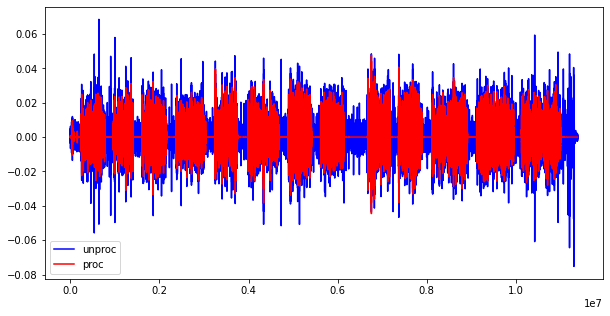

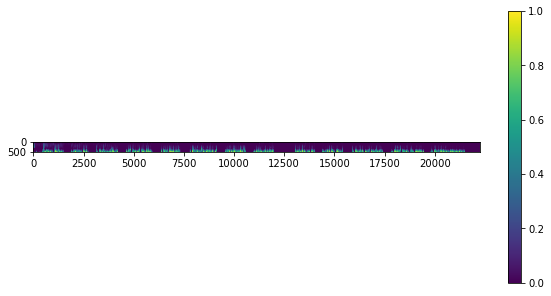

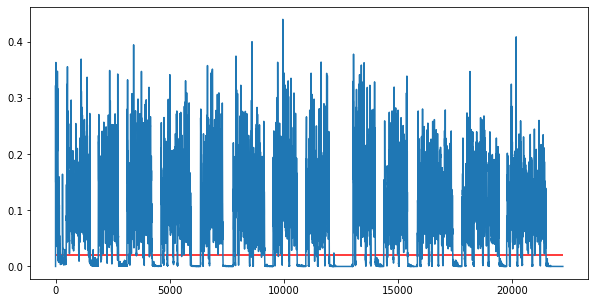

0.09346515960700222


<ipython-input-26-d957bbf90d18>:3: FutureWarning: Pass orig_sr=16000, target_sr=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  if not sr==p.sr: y = librosa.resample(y, sr, p.sr)


(24427, 513)


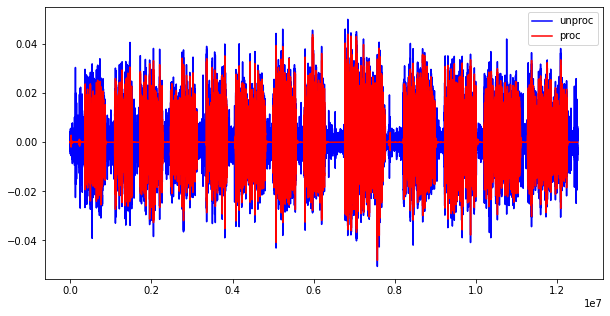

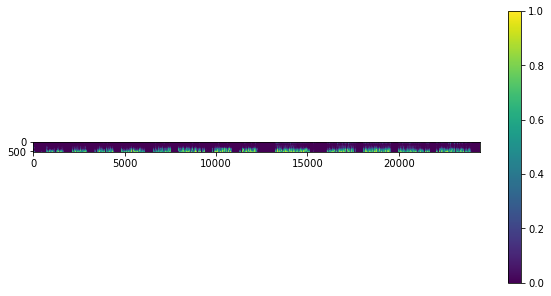

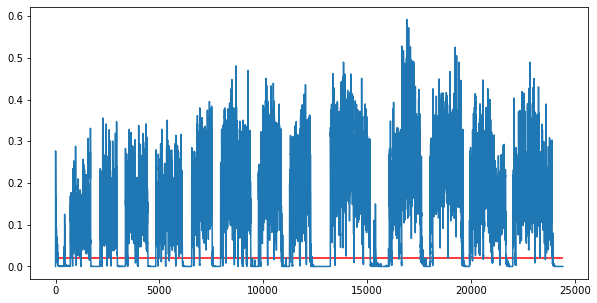

0.1024593671833141


In [29]:
import time
model.reset_states()  
    
r_erb_list, r_spec_list = [],[]
r_state_list, r_state10_list, r_state11_list, r_state20_list, r_state21_list = [],[],[],[],[]
buffer_frame = 1
for file in audiofile:
    start = time.time()
    if stateful:
        num_frame, r_erb, r_spec = process(file)
    else:
        num_frame, r_erb, r_spec, r_state, r_state10, r_state11, r_state20, r_state21 = process(file)
    end = time.time()
    print((end-start)/num_frame)
    
    r_erb_list.append(r_erb)
    r_spec_list.append(r_spec)
    if not stateful:
        r_state_list.append(r_state)
        r_state10_list.append(r_state10)
        r_state11_list.append(r_state11)
        r_state20_list.append(r_state20)
        r_state21_list.append(r_state21)

# if not os.path.isdir('./quantize_npy'): os.makedirs('./quantize_npy')
# np.save('./quantize_npy/whole_erb.npy', np.concatenate(r_erb_list,0))
# np.save('./quantize_npy/whole_spec.npy',np.concatenate(r_spec_list,0))
# np.save('./quantize_npy/whole_state.npy',np.concatenate(r_state_list,0))
# np.save('./quantize_npy/whole_state10.npy',np.concatenate(r_state10_list,0))
# np.save('./quantize_npy/whole_state11.npy',np.concatenate(r_state11_list,0))
# np.save('./quantize_npy/whole_state20.npy',np.concatenate(r_state20_list,0))
# np.save('./quantize_npy/whole_state21.npy',np.concatenate(r_state21_list,0))

In [30]:
from numba import cuda
device=cuda.get_current_device()
device.reset()

INFO:numba.cuda.cudadrv.driver:init
ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


CudaSupportError: Error at driver init: 
[100] Call to cuInit results in CUDA_ERROR_NO_DEVICE:

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model_quant)

# Quant

In [ ]:
quant_erb = np.load('./quantize_npy/whole_erb_half.npy')
quant_spec = np.load('./quantize_npy/whole_spec_half.npy')
quant_state0 = np.load('./quantize_npy/whole_state_half.npy')
quant_state10 = np.load('./quantize_npy/whole_state10_half.npy')
quant_state11 = np.load('./quantize_npy/whole_state11_half.npy')
quant_state20 = np.load('./quantize_npy/whole_state20_half.npy')
quant_state21 = np.load('./quantize_npy/whole_state21_half.npy')

In [ ]:
quant_erb = np.concatenate((np.zeros((2,32,1)),quant_erb),axis=0)
quant_spec = np.concatenate((np.zeros((2,96,2)),quant_spec),axis=0)

In [ ]:
range_list = [i for i in range(quant_state21.shape[0])]
random.shuffle(range_list)

In [ ]:
def representative_data_gen():
    for j in range_list:
        yield [
               quant_spec[j:j+3].reshape(1,3,96,2).astype(np.float32), 
               quant_state11[j].reshape(1,256).astype(np.float32), 
               quant_state10[j].reshape(1,256).astype(np.float32), 
               quant_state21[j].reshape(1,256).astype(np.float32), 
               quant_state20[j].reshape(1,256).astype(np.float32),
               quant_erb[j:j+3].reshape(1,3,32,1).astype(np.float32), 
               quant_state0[j].reshape(1,256).astype(np.float32)
        ]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8] 
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int16
converter.inference_output_type = tf.int16

tflite_model_quant = converter.convert()
with open('INT16_model.tflite', 'wb') as f:
    f.write(tflite_model_quant)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()
with open('FP32_model.tflite', 'wb') as f:
    f.write(tflite_model_quant)